<a href="https://colab.research.google.com/github/sricharithanarra/Named-Entity-Recognition-for-Medical-Text/blob/main/randomforest_Dataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report
from pprint import pprint

In [ ]:
# Read the training and test dataset -- Took a minute

train_df = pd.read_csv('processed_train(1).csv', low_memory=False)
test_df = pd.read_csv('processed_test.csv', low_memory=False)
pprint(f'Train dataset shape: {train_df.shape}')
pprint(f'Test dataset shape: {test_df.shape}')

'Train dataset shape: (1025602, 221)'
'Test dataset shape: (134529, 221)'


Dataset is imbalanced. Need to explore more.

In [ ]:
# Info about data and categorical columns
train_df.info()
categorical_column_data_types = {col: train_df[col].dtype for col in train_df.columns if train_df[col].dtype == 'O'}
pprint(categorical_column_data_types)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025602 entries, 0 to 1025601
Columns: 221 entries, Unnamed: 0 to Are you of Asian descent?
dtypes: float64(208), int64(2), object(11)
memory usage: 1.7+ GB
{'Characterize your pain:': dtype('O'),
 'Do you feel pain somewhere?': dtype('O'),
 'Do your lesions peel off?': dtype('O'),
 'Does the pain radiate to another location?': dtype('O'),
 'Have you traveled out of the country in the last 4 weeks?': dtype('O'),
 'Is the lesion (or are the lesions) larger than 1cm?': dtype('O'),
 'PATHOLOGY': dtype('O'),
 'SEX': dtype('O'),
 'What color is the rash?': dtype('O'),
 'Where is the affected region located?': dtype('O'),
 'Where is the swelling located?': dtype('O')}


We have 10 categorical columns that need to encoded.

In [ ]:
# View values of categorical columns
unique_values = {col: train_df[col].unique() for col in train_df.columns if train_df[col].dtype == 'O'}
pprint(unique_values)


{'Characterize your pain:': array(['heavy', 'exhausting', 'sharp', 'burning', 'a cramp', '0',
       'heartbreaking', 'sickening', 'sensitive', 'scary',
       'a knife stroke', 'tugging', 'violent', 'a pulse', 'haunting',
       'tedious', nan], dtype=object),
 'Do you feel pain somewhere?': array(['temple(L)', 'posterior chest wall(L)', 'eye(R)', 'pharynx', '0',
       'temple(R)', 'epigastric', 'breast(L)', 'iliac fossa(L)', 'pubis',
       'occiput', 'testicle(L)', 'posterior chest wall(R)', 'shoulder(L)',
       'under the jaw', 'hypochondrium(R)', 'forehead', 'trachea',
       'sole(L)', 'finger (middle)(R)', 'shoulder(R)', 'breast(R)',
       'dorsal aspect of the foot(L)', 'belly', 'eye(L)', 'nose',
       'hip(L)', 'top of the head', 'triceps(R)', 'finger (middle)(L)',
       'ear(L)', 'ear(R)', 'nowhere', 'sole(R)', 'upper chest',
       'cheek(L)', 'hypochondrium(L)', 'knee(R)', 'back of head',
       'palace', 'testicle(R)', 'lower chest',
       'dorsal aspect of the foot(

In [ ]:
# Check if there are any nans values
pprint(train_df.columns[train_df.isna().any()].tolist())
pprint(test_df.columns[test_df.isna().any()].tolist())

['Characterize your pain:', 'What color is the rash?']
['Characterize your pain:', 'What color is the rash?']


In [ ]:
# Count of NAN in the columns -- drop these rows

print(train_df['Characterize your pain:'].isna().sum())
print(train_df['What color is the rash?'].isna().sum())
print(test_df['Characterize your pain:'].isna().sum())
print(test_df['What color is the rash?'].isna().sum())

10859
32609
1379
4436


In [ ]:
# Drop rows with NAN values

train_df_nonan = train_df.dropna(subset=['Characterize your pain:', 'What color is the rash?'])
test_df_nonan = test_df.dropna(subset=['Characterize your pain:', 'What color is the rash?'])

In [ ]:
# Count of NAN in the columns after drop

print(train_df_nonan['Characterize your pain:'].isna().sum())
print(train_df_nonan['What color is the rash?'].isna().sum())
print(test_df_nonan['Characterize your pain:'].isna().sum())
print(test_df_nonan['What color is the rash?'].isna().sum())

0
0
0
0


In [ ]:
pprint(f'Train dataset shape: {train_df_nonan.shape}')
pprint(f'Test dataset shape: {test_df_nonan.shape}')

'Train dataset shape: (982224, 221)'
'Test dataset shape: (128726, 221)'


In [ ]:
# Prepare training and test variables
X_columns = [col for col in train_df_nonan.columns if col not in ['Unnamed: 0', 'PATHOLOGY']]
X_train = train_df_nonan[X_columns]
y_train = train_df_nonan['PATHOLOGY']
X_test = test_df_nonan[X_columns]
y_test = test_df_nonan['PATHOLOGY']
pprint(f'X_train shape: {X_train.shape}')
pprint(f'y_train shape: {y_train.shape}')
pprint(f'X_test shape: {X_test.shape}')
pprint(f'y_test shape: {y_test.shape}')


'X_train shape: (982224, 219)'
'y_train shape: (982224,)'
'X_test shape: (128726, 219)'
'y_test shape: (128726,)'


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize a label encoder
le = LabelEncoder()

categorical_columns = list(unique_values.keys())
# Remove Pathology column - Not needed for Decision Trees
categorical_columns.remove('PATHOLOGY')

# Reset indices of both X_train and X_test
X_train_reset = X_train.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)

# Combine the train and test data
combined = pd.concat([X_train_reset, X_test_reset], axis=0)

# Label encode the combined dataframe for each categorical column
for col in categorical_columns:
    combined[col] = le.fit_transform(combined[col])

combined_encoded = combined

# Split the combined_encoded dataframe back into train and test
X_train_encoded = combined_encoded.iloc[:len(X_train)]
X_test_encoded = combined_encoded.iloc[len(X_train):]

In [ ]:
# Check dimension after encoding
pprint(f'X_train shape: {X_train_encoded.shape}')
pprint(f'X_test shape: {X_test_encoded.shape}')

'X_train shape: (982224, 219)'
'X_test shape: (128726, 219)'


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# randomforest
# Initialize the RandomForestClassifier with a random_state of 42
rfc = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rfc.fit(X_train_encoded, y_train)

# Make predictions on the testing data
y_pred = rfc.predict(X_test_encoded)


In [ ]:
# Evaluate the Model

accuracy = accuracy_score(y_test, y_pred)
print(f'The accuracy score is {accuracy * 100:.2f}%')
print("Classification Report")
print(classification_report(y_test, y_pred))

The accuracy score is 99.36%
Classification Report
                                          precision    recall  f1-score   support

     Acute COPD exacerbation / infection       1.00      1.00      1.00      2153
                Acute dystonic reactions       1.00      1.00      1.00      3302
                        Acute laryngitis       0.99      0.99      0.99      3214
                      Acute otitis media       1.00      1.00      1.00      3509
                   Acute pulmonary edema       1.00      1.00      1.00      2598
                    Acute rhinosinusitis       0.86      0.73      0.79      1829
                      Allergic sinusitis       1.00      1.00      1.00      2411
                             Anaphylaxis       1.00      1.00      1.00      3798
                                  Anemia       1.00      1.00      1.00      6770
                     Atrial fibrillation       1.00      1.00      1.00      2831
                               Boerhaave      

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

array([[2153,    0,    0, ...,    0,    0,    0],
       [   0, 3302,    0, ...,    0,    0,    0],
       [   0,    0, 3191, ...,    0,   23,    0],
       ...,
       [   0,    0,    0, ..., 2832,    0,    0],
       [   0,    0,   28, ...,    0, 8305,    0],
       [   0,    0,    0, ...,    0,    0,  549]], dtype=int64)

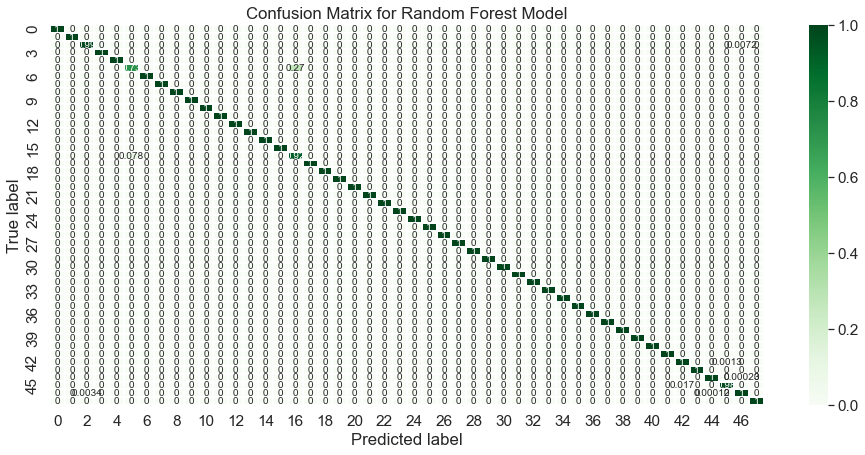

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [ ]:
X = X_train_encoded
y = y_train

In [ ]:
scores = cross_val_score(rfc, X, y, cv=kf, scoring='accuracy')

In [ ]:
for fold, score in enumerate(scores):
    print(f"Fold {fold+1} Score: {score:.4f}")

Fold 1 Score: 0.9939
Fold 2 Score: 0.9939
Fold 3 Score: 0.9941
Fold 4 Score: 0.9939
Fold 5 Score: 0.9938


In [ ]:
mean_score = np.mean(scores)
std_score = np.std(scores)
print(f"Mean Score: {mean_score:.4f}")
print(f"Standard Deviation: {std_score:.4f}")

Mean Score: 0.9939
Standard Deviation: 0.0001
